<a href="https://colab.research.google.com/github/MinsuChoKW/Data-Analytics-2025/blob/main/week4_event_logs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Week 4 - 이벤트 로그 · 프로세스 마이닝 (PM4Py)

- 이 노트북은 **최신 PM4Py** 버전(권장: 2.7 이상) 기준으로 작성되었다.  
- 실습 항목: 이벤트 로그 로드, 간단 전처리, Dotted Chart 등 확인
- 오류가 발생하면 아래 환경 점검 셀을 먼저 실행해 버전을 확인하고, 필요 시 pip 설치 주석을 해제하여라.

In [1]:
# ✅ 환경 점검: PM4Py 버전 확인 (필요 시 설치)
try:
    import pm4py
    print("pm4py version:", pm4py.__version__)
except Exception as e:
    print("pm4py가 설치되어 있지 않거나 환경 문제가 있습니다.")
    print("Colab/로컬에서 아래 주석을 해제해 설치하세요:")
    print("!pip install -U pm4py")

pm4py가 설치되어 있지 않거나 환경 문제가 있습니다.
Colab/로컬에서 아래 주석을 해제해 설치하세요:
!pip install -U pm4py


## 환경 설정 (Setup)

본 노트북에서는 아래의 라이브러리를 활용한다:

* [PM4Py](https://pm4py.fit.fraunhofer.de/)
* [pandas](https://pandas.pydata.org/)
* [matplotlib](https://matplotlib.org)


In [32]:
import pandas as pd
import pm4py
import matplotlib.pyplot as plt

## 이벤트 로그 (Event Logs)
이 부분에서는 이벤트 로그와 프로세스 마이닝 방법의 기반이 되는 고유한 속성을 소개한다.. 본 실습을 위해서는 `data` 디렉토리에 있는 CSV 파일에서 로드해야 한다. 이 강의에서는 다음 데이터셋을 사용할 것이다:

* Patients: 병원 환경에서 합성적으로 생성된 예제 이벤트 로그이다.
* Sepsis: 네덜란드 병원에서 가져온 실제 이벤트 로그이다. 이 이벤트 로그는 다음에서 공개적으로 사용할 수 있으며 많은 프로세스 마이닝 관련 출판물에서 사용되었다: https://doi.org/10.4121/uuid:915d2bfb-7e84-49ad-a286-dc35f063a460

### Import Patients Data

In [57]:
patients = pd.read_csv("/content/data/patients.csv", sep=';')
patients['time'] = pd.to_datetime(patients['time'])
num_rows = len(patients)
print("Number of rows: {}".format(num_rows))

Number of rows: 5442


### Import Sepsis Data

In [8]:
sepsis = pd.read_csv("/content/data/sepsis.csv", sep=';')
num_rows = len(sepsis)
sepsis['timestamp'] = pd.to_datetime(sepsis['timestamp'])
print("Number of rows: {}".format(num_rows))

Number of rows: 15214


### Exploring Event Data

우선 이벤트 로그의 구조나 특성에 대한 사전 지식 없이 이벤트 데이터를 탐색해 본다. 이를 위해 표준 Pandas와 Matplotlib를 활용한다.

데이터 내 Timestamp의 포멧 변경을 위하여 아래의 항목을 적용한다.

In [58]:
patients['time'] = pd.to_datetime(patients['time'], utc=True, errors='coerce').dt.tz_convert(None)
patients['time'] = patients['time'].astype('datetime64[ns]')

In [101]:
sepsis['timestamp'] = pd.to_datetime(sepsis['timestamp'], utc=True, errors='coerce').dt.tz_convert(None)
sepsis['timestamp'] = sepsis['timestamp'].astype('datetime64[ns]')

In [102]:
sepsis.head()

,case_id,activity,lifecycle,resource,timestamp,age,crp,diagnose,diagnosticartastrup,diagnosticblood,...,lacticacid,leucocytes,oligurie,sirscritheartrate,sirscritleucos,sirscrittachypnea,sirscrittemperature,sirscriteria2ormore,activity_instance_id,.order
0,A,ER Registration,complete,A,2014-10-22 11:15:41,85.0,NaN,A,True,True,...,NaN,NaN,False,True,False,True,True,True,1,1
1,A,Leucocytes,complete,B,2014-10-22 11:27:00,NaN,NaN,NaN,NaN,NaN,...,NaN,9.6,NaN,NaN,NaN,NaN,NaN,NaN,2,2
2,A,CRP,complete,B,2014-10-22 11:27:00,NaN,210.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3
3,A,LacticAcid,complete,B,2014-10-22 11:27:00,NaN,NaN,NaN,NaN,NaN,...,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4
4,A,ER Triage,complete,C,2014-10-22 11:33:37,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5


이벤트 로그에서 가장 중요한 요소는 `time` 이다. 이를 통해 이벤트들의 순서를 확립할 수 있다.

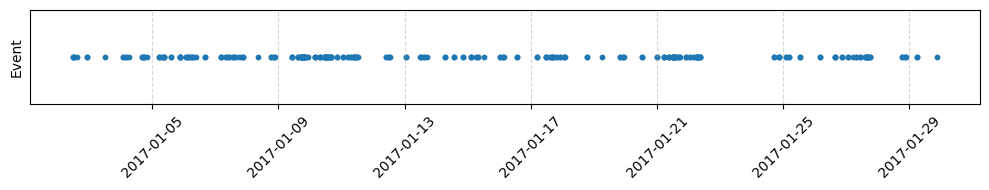

In [61]:
t = pd.to_datetime(patients['time'])

x = t[t < pd.Timestamp('2017-01-31')].dropna()

plt.figure(figsize=(10, 2))
plt.scatter(x, [0]*len(x), s=10)
plt.ylabel("Event")
plt.yticks([])
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

또한 어떤 종류의 행동이나 `활동(activities)`이 수행되었는지에 대한 정보도 필요하다.

In [62]:
patients.drop_duplicates(subset='handling')[["handling"]]

,handling
0,Registration
500,Triage and Assessment
1000,Blood test
1237,MRI SCAN
1473,X-Ray
1734,Discuss Results
2229,Check-out


다른 어떤 데이터가 있는지 한번 살펴보자.

In [63]:
patients.drop_duplicates(subset='patient')[["patient"]].head()

,patient
0,1
1,2
2,3
3,4
4,5


아마도 환자 식별자가 프로세스의 `케이스(case)`를 정의하는 데 좋은 후보가 될 수 있을 것이다. 이는 우리가 추적하고자 하는 '엔티티'이기 때문이다. 개별 환자별로 발생한 이벤트 수를 세어보면, 각 환자마다 유사한 이벤트 개수가 나타나는데, 이는 일반적으로 프로세스 케이스 식별자를 정하는 데 좋은 지표가 된다.

In [64]:
patients.groupby(['patient'])["patient"].agg(['count']).head()

,count
patient,
1,12
2,10
3,12
4,12
5,10


환자 식별자를 `케이스 식별자(case identifier)`로 삼아 프로세스를 따라가기로 하자.

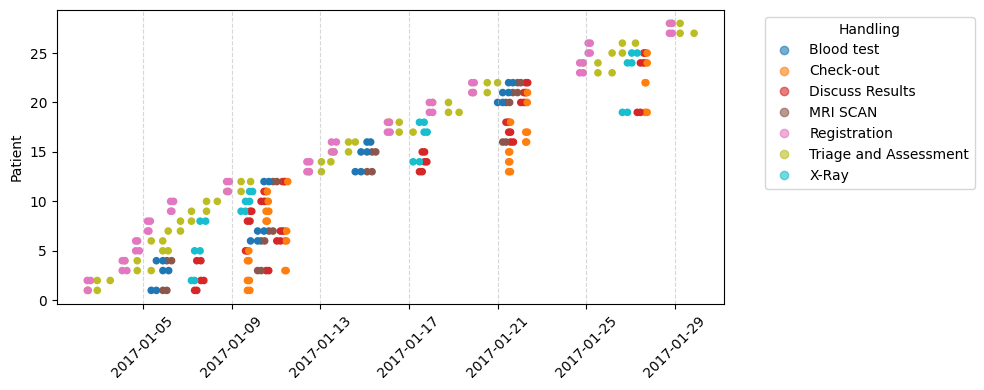

In [65]:
patients['time'] = pd.to_datetime(patients['time'])
patients_sample = patients[patients['time'] < pd.Timestamp('2017-01-31')].dropna(subset=['time'])

plt.figure(figsize=(10, 4))
scatter = plt.scatter(
    patients_sample['time'],
    patients_sample['patient'],
    c=pd.Categorical(patients_sample['handling']).codes,
    cmap='tab10',
    s=20
)

plt.ylabel("Patient")
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.5)

handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles, pd.Categorical(patients_sample['handling']).categories,
           title="Handling", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

위 산점도는 프로세스 마이닝 분야에서 `도트 차트(Dotted Chart)`라고 불리며, 케이스 단위로 묶었을 때 이벤트와 그 시간적 관계를 한눈에 보여준다. 각 이벤트 시퀀스(`트레이스`라고도 함)는 `등록(Registration)` 이벤트로 시작하는 것처럼 보인다. 이제 이벤트 데이터를 환자 식별자와 시간 기준으로 정렬해서 살펴보자.

In [66]:
patients.sort_values(['patient', 'time']).head(14)

,handling,patient,employee,handling_id,registration_type,time,.order
0,Registration,1,r1,1,start,2017-01-02 11:41:53,1
500,Triage and Assessment,1,r2,501,start,2017-01-02 12:40:20,501
2721,Registration,1,r1,1,complete,2017-01-02 12:40:20,2722
3221,Triage and Assessment,1,r2,501,complete,2017-01-02 22:32:25,3222
1000,Blood test,1,r3,1001,start,2017-01-05 08:59:04,1001
3721,Blood test,1,r3,1001,complete,2017-01-05 14:34:27,3722
1237,MRI SCAN,1,r4,1238,start,2017-01-05 21:37:12,1238
3958,MRI SCAN,1,r4,1238,complete,2017-01-06 01:54:23,3959
1734,Discuss Results,1,r6,1735,start,2017-01-07 07:57:49,1735
4455,Discuss Results,1,r6,1735,complete,2017-01-07 10:18:08,4456


개별 프로세스 실행(예: 환자 1의 경우)은 여러 활동이 순차적으로 수행되는 것으로 구성된다. 하지만 단순히 이벤트의 순서만 있는 것이 아니라 더 많은 정보가 주어진다. 각 활동의 발생에는 두 개의 이벤트가 있는데, 하나는 `start` 이벤트이고 다른 하나는 `complete` 이벤트이며 이는 `registration_type` 열에 기록된다. 이러한 이벤트들은 활동의 라이프사이클을 나타내며, 활동의 `지속 시간(duration)`을 측정할 수 있게 한다.

### Further resources

* [XES Standard](http://xes-standard.org/)
* [Importing XES event logs](https://processintelligence.solutions/pm4py/api?page=pm4py.html%23pm4py.read.read_xes)

####성찰 질문(Reflection Questions)
* 왜 이 데이터셋에 `.order`라는 열이 포함되어 있을까?
* `employee` 열은 어떻게 활용할 수 있을까?
* `handling_id` 열은 어떤 용도로 쓰이며, 어떤 상황에서 필요할까?

## Basic Process Visualization

### Dotted Chart

`Dotted Chart`는 각 트레이스의 시간적 측면을 더해주고, 모든 트레이스를 한눈에 시각화한다. 다양한 방식으로 설정할 수 있어 프로세스 동작의 시간 관련 특성을 이해하는 데 유용하다. PM4Py는 기본적인 Dotted Chart 시각화를 제공한다.

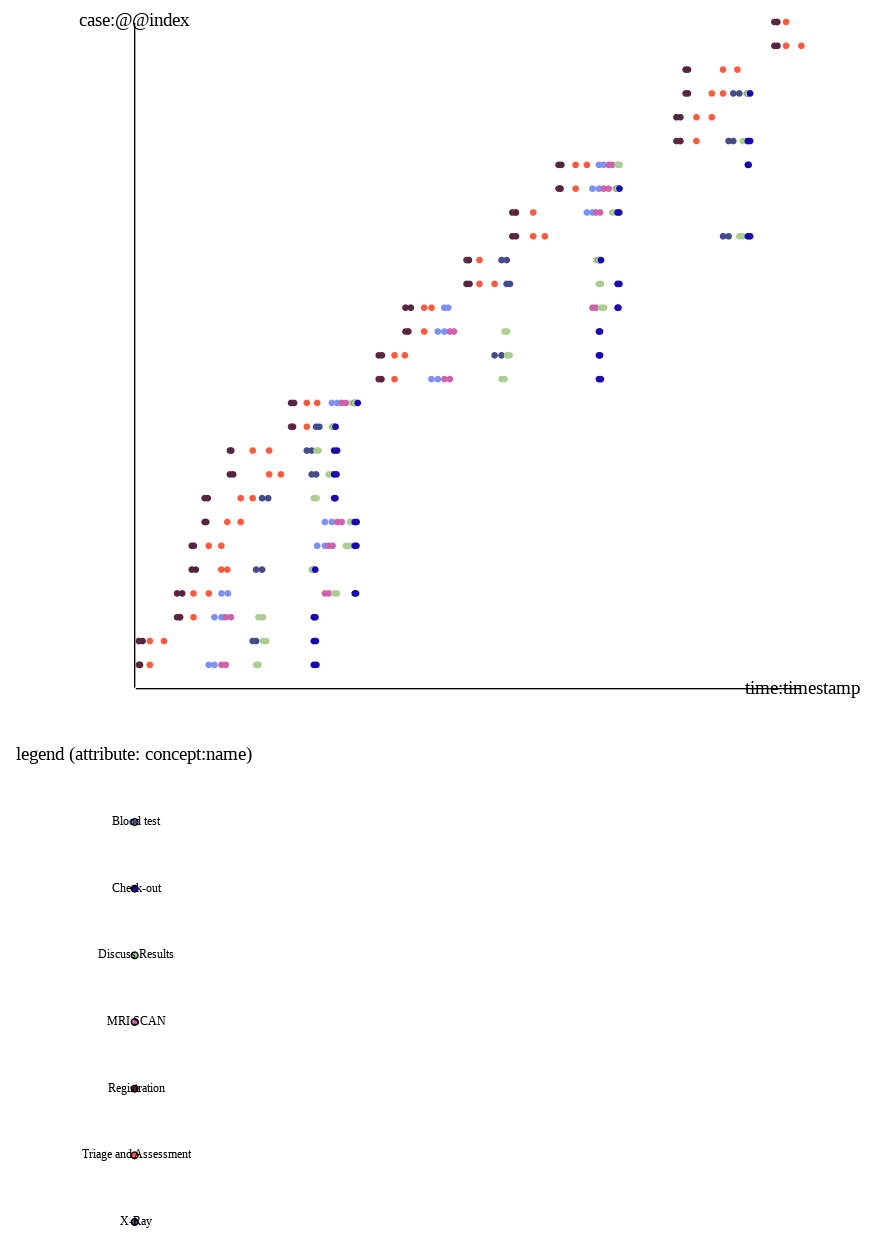

In [67]:
patients_log = pm4py.format_dataframe(patients, case_id='patient', activity_key='handling', timestamp_key='time')
pm4py.view_dotted_chart(pm4py.filter_time_range(patients_log, "1970-01-01 00:00:00", "2017-01-31 00:00:00", mode='events'))

대안적으로, 시각화를 더 세밀하게 커스터마이즈하기 위해 동일한 뷰를 plt를 사용해 간단히 재현할 수 있으며, 이를 통해 관점 선택에서 더 큰 유연성을 가질 수 있다.

In [68]:
# Necessary pre-processing on the data frame
patients_sorted = patients.sort_values(['time'])
# Creating categories for the case identifier
patients_sorted['patient'] = pd.Categorical(patients_sorted['patient'],
                                            categories = patients_sorted['patient'].drop_duplicates().tolist()[::-1], ordered= True)

#### Absolute Time Dimension

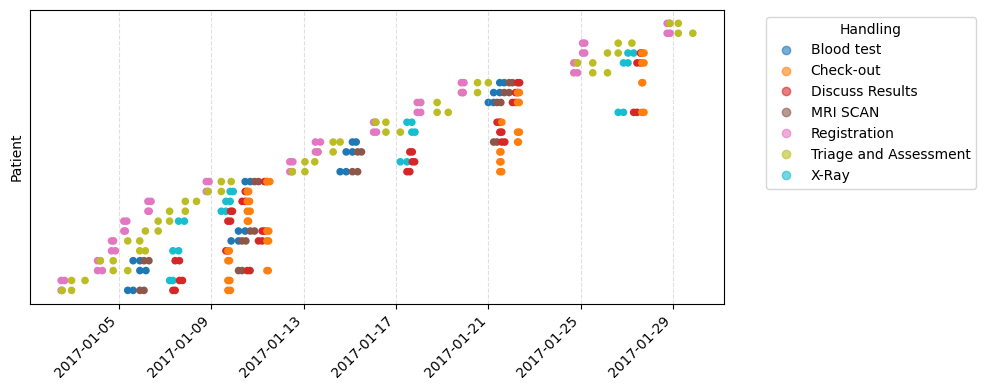

In [70]:
# 1) time 컬럼 정리 (UTC → naive datetime)
df = patients_sorted.copy()
df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce').dt.tz_convert(None)

# 2) 2017-01-31 이전 데이터만 필터
df = df[df['time'] < pd.Timestamp('2017-01-31')].dropna(subset=['time'])

# 3) 산점도 (handling → 색상)
plt.figure(figsize=(10, 4))
scatter = plt.scatter(
    df['time'],
    df['patient'],
    c=pd.Categorical(df['handling']).codes,
    cmap='tab10',
    s=20
)

# 4) 축/레이블 설정
plt.xticks(rotation=45, ha='right')
plt.ylabel("Patient")
plt.yticks([])  # y축 라벨 숨기기
plt.grid(axis='x', linestyle='--', alpha=0.4)

# 5) 범례
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles,
           pd.Categorical(df['handling']).categories,
           title="Handling",
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### Relative Time Dimension

We meed to make the time relative and add a new column `time_relative` for that purpose:

In [71]:
patients_sorted['time_relative'] = patients_sorted['time'].sub( patients_sorted.groupby('patient')['time'].transform('first'))

/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


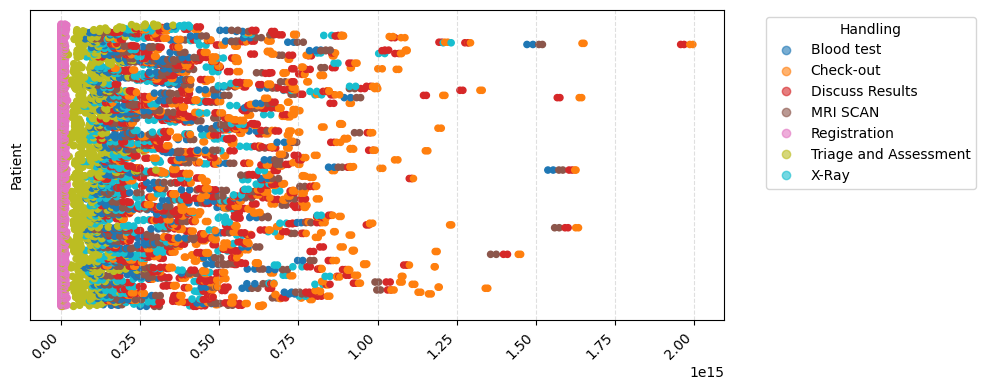

In [73]:
df = patients_sorted.copy()

plt.figure(figsize=(10, 4))
scatter = plt.scatter(
    df['time_relative'],
    df['patient'],
    c=pd.Categorical(df['handling']).codes,
    cmap='tab10',
    s=20
)

# 축 설정
plt.xticks(rotation=45, ha='right')
plt.ylabel("Patient")
plt.yticks([])  # y축 라벨 제거
plt.grid(axis='x', linestyle='--', alpha=0.4)

# 범례
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles,
           pd.Categorical(df['handling']).categories,
           title="Handling",
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

We still need to sort by the overall duration to replicate the `bupaR`

In [83]:
patients_sorted['duration'] = patients_sorted.groupby('patient')['time_relative'].transform('max')

/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


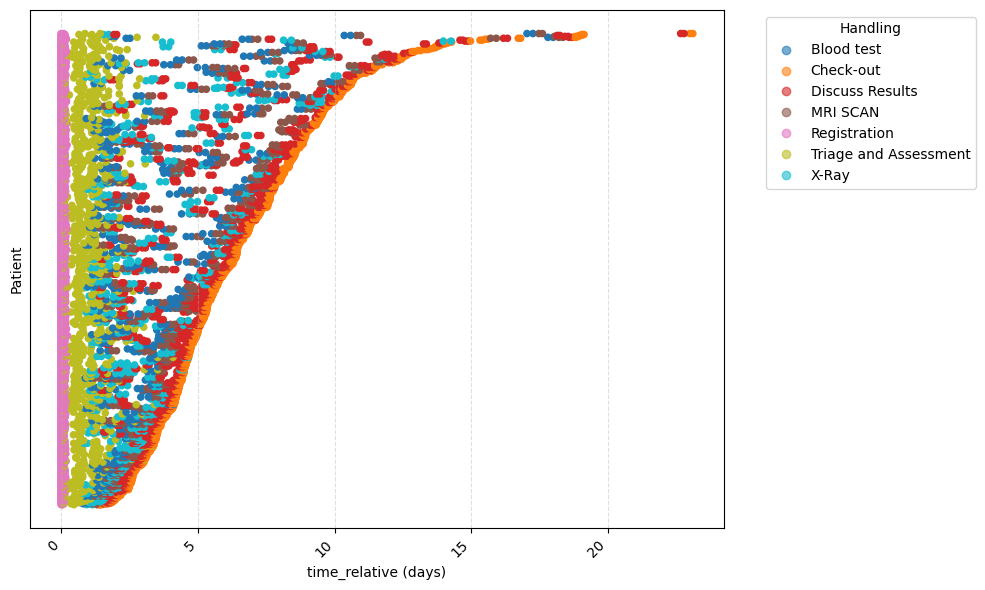

In [91]:
df = patients_sorted.sort_values(['duration']).copy()
df['patient'] = pd.Categorical(
    df['patient'],
    categories=df['patient'].drop_duplicates().tolist()[::-1],
    ordered=True
)

# timedelta → float(일 단위) 변환 + NaT 제거
x = pd.to_timedelta(df['time_relative'], errors='coerce')
mask = x.notna()
x_days = x[mask].dt.total_seconds() / 86400.0

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x_days,
    df.loc[mask, 'patient'].astype(str),
    c=pd.Categorical(df.loc[mask, 'handling']).codes,
    cmap='tab10',
    s=20
)

plt.xlabel("time_relative (days)")
plt.ylabel("Patient")
plt.yticks([])  # y축 라벨 숨김
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.4)

handles, _ = scatter.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles,
           pd.Categorical(df.loc[mask, 'handling']).categories,
           title="Handling",
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

PM4Py에서 제공하는 다른 기본적인 프로세스 시각화 옵션.

* [Basic Process Statistics](https://processintelligence.solutions/pm4py/api?page=pm4py.html%23module-pm4py.stats)

## Process Map Visualization

마찬가지로, PM4Py에는 내장된 선행 관계 행렬(Precedence Matrix) 시각화 기능이 없지만, 이를 손쉽게 재현할 수 있다.

In [92]:
patients_sorted['antecedent'] = patients_sorted.groupby(["patient"])['handling'].shift(1).fillna("Start")
patients_sorted['consequent'] = patients_sorted['handling']

/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


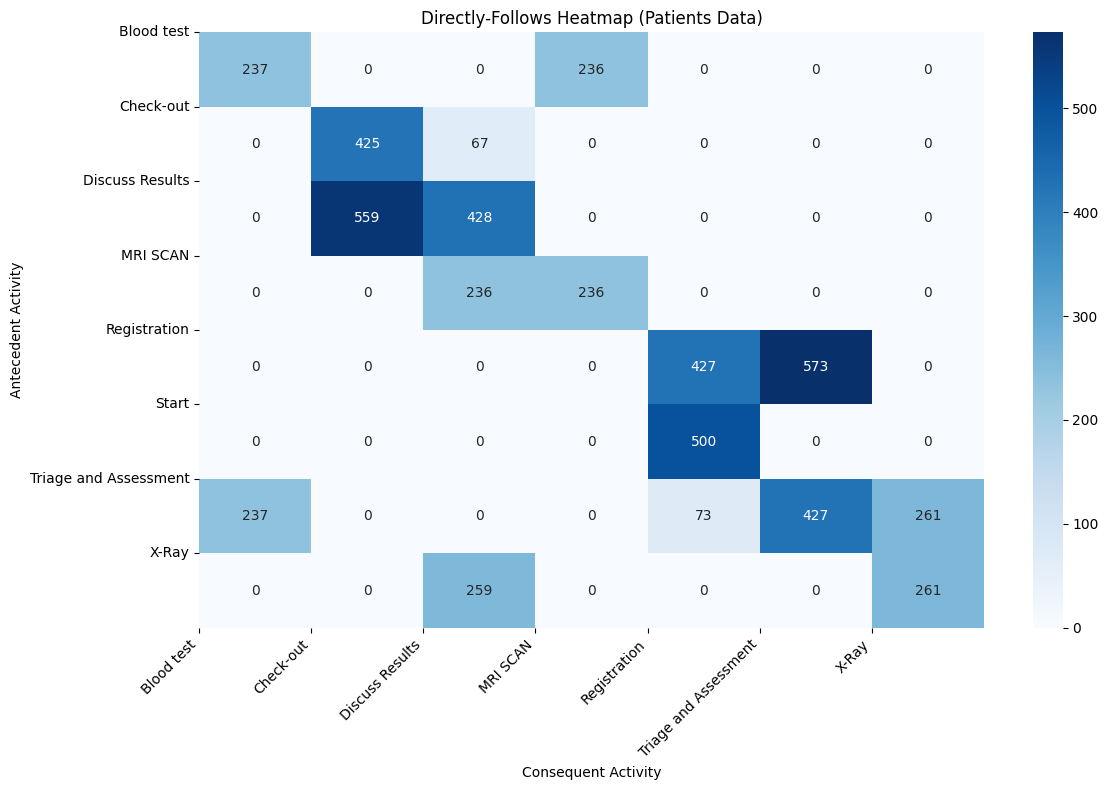

In [126]:
(ggplot(patients_sorted, aes('consequent', 'antecedent', ))
 + geom_bin2d()
 + theme_bw()
 + theme(axis_text_x=element_text(rotation=45, hjust=1)))

### Directly-follows Graph / Process Map

아래는 다음 구현에서 자세히 다룰 Process Discovery에 한 예인 DFG를 나타낸다.

In [94]:
patients_log = patients_log[patients_log['registration_type'] == 'complete']

In [95]:
dfg, sa, ea = pm4py.discover_directly_follows_graph(patients_log)

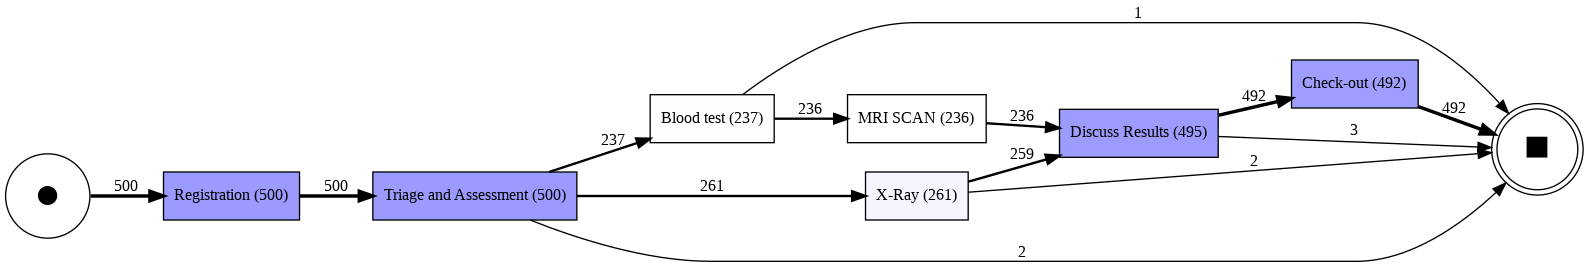

In [96]:
pm4py.view_dfg(dfg, sa, ea)

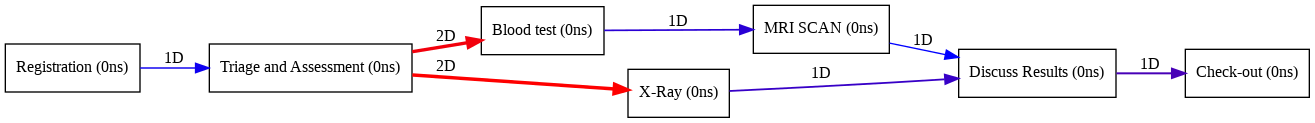

In [97]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

dfg = dfg_discovery.apply(patients_log)

dfg = dfg_discovery.apply(patients_log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=patients_log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

## Real-life Processes

In [98]:
sepsis

,case_id,activity,lifecycle,resource,timestamp,age,crp,diagnose,diagnosticartastrup,diagnosticblood,...,lacticacid,leucocytes,oligurie,sirscritheartrate,sirscritleucos,sirscrittachypnea,sirscrittemperature,sirscriteria2ormore,activity_instance_id,.order
0,A,ER Registration,complete,A,2014-10-22 11:15:41+00:00,85.0,NaN,A,True,True,...,NaN,NaN,False,True,False,True,True,True,1,1
1,A,Leucocytes,complete,B,2014-10-22 11:27:00+00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,9.6,NaN,NaN,NaN,NaN,NaN,NaN,2,2
2,A,CRP,complete,B,2014-10-22 11:27:00+00:00,NaN,210.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3
3,A,LacticAcid,complete,B,2014-10-22 11:27:00+00:00,NaN,NaN,NaN,NaN,NaN,...,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4
4,A,ER Triage,complete,C,2014-10-22 11:33:37+00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15209,KNA,CRP,complete,B,2014-12-16 07:00:00+00:00,NaN,660.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15210,15210
15210,KNA,Release A,complete,E,2014-12-16 17:00:00+00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15211,15211
15211,LNA,ER Registration,complete,L,2014-12-03 10:50:28+00:00,50.0,NaN,NaN,False,False,...,NaN,NaN,False,False,False,False,False,False,15212,15212
15212,LNA,ER Triage,complete,C,2014-12-03 10:54:19+00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15213,15213


In [103]:
sepsis_sorted = sepsis.sort_values(['timestamp'])
sepsis_sorted['timestamp'] = pd.to_datetime(sepsis_sorted['timestamp'])

In [104]:
sepsis_sorted['antecedent'] = sepsis_sorted.groupby(["case_id"])['activity'].shift(1).fillna("Start")
sepsis_sorted['consequent'] = sepsis_sorted['activity']

In [107]:
sepsis_sorted

,case_id,activity,lifecycle,resource,timestamp,age,crp,diagnose,diagnosticartastrup,diagnosticblood,...,oligurie,sirscritheartrate,sirscritleucos,sirscrittachypnea,sirscrittemperature,sirscriteria2ormore,activity_instance_id,.order,antecedent,consequent
3833,XJ,ER Registration,complete,A,2014-03-31 11:32:08,90.0,NaN,C,False,True,...,False,True,False,False,True,True,3834,3834,Start,ER Registration
3834,XJ,ER Triage,complete,C,2014-03-31 11:33:47,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3835,3835,ER Registration,ER Triage
3835,XJ,ER Sepsis Triage,complete,A,2014-03-31 11:45:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3836,3836,ER Triage,ER Sepsis Triage
3836,XJ,LacticAcid,complete,B,2014-03-31 11:45:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3837,3837,ER Sepsis Triage,LacticAcid
3837,XJ,Leucocytes,complete,B,2014-03-31 11:49:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3838,3838,LacticAcid,Leucocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,X,Return ER,complete,?,2013-11-24 08:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,279,279,Release A,Return ER
8887,QW,Return ER,complete,?,2014-08-09 08:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8888,8888,Release A,Return ER
10887,UBA,Return ER,complete,?,2014-09-28 07:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10888,10888,Release A,Return ER
8957,UW,Return ER,complete,?,2014-08-10 13:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8958,8958,Release A,Return ER


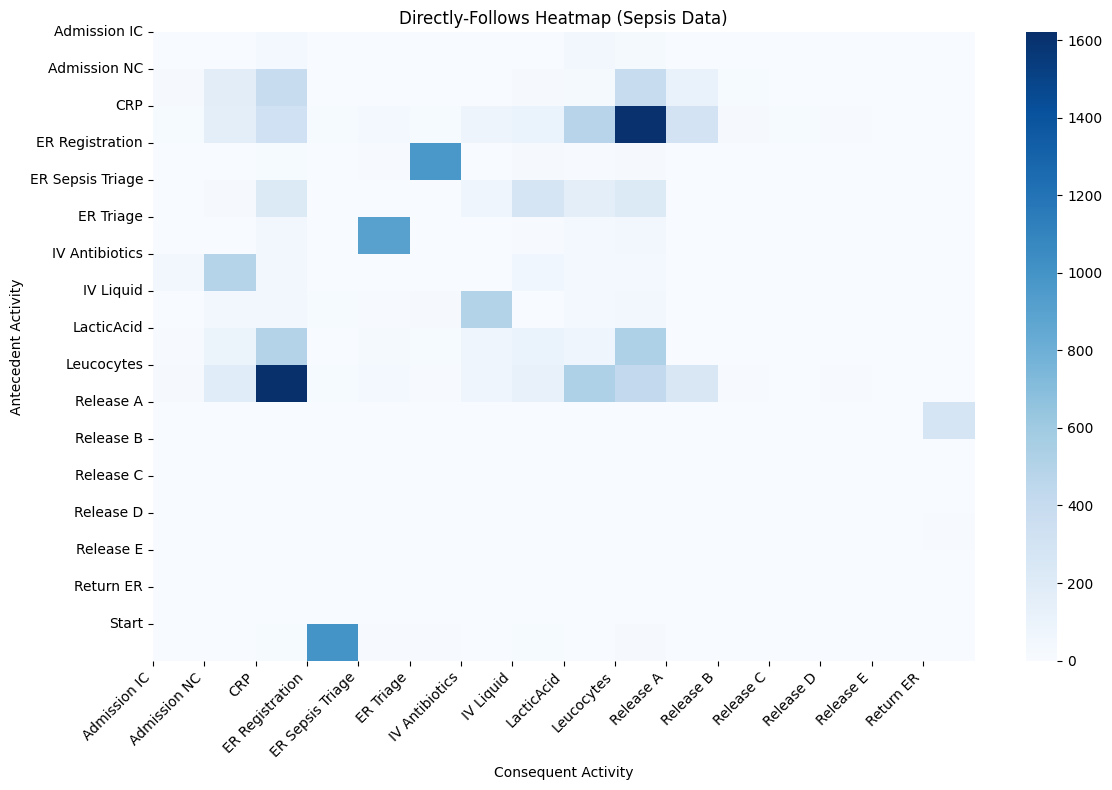

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Calculate the frequency of antecedent and consequent pairs
transition_counts = sepsis_sorted.groupby(['antecedent', 'consequent']).size().reset_index(name='count')

# Create a pivot table for the heatmap
heatmap_data = transition_counts.pivot(index='antecedent', columns='consequent', values='count').fillna(0)

# Plot the heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=False, fmt='d') # Changed colormap to 'Blues'
plt.title('Directly-Follows Heatmap (Sepsis Data)')
plt.xlabel('Consequent Activity')
plt.ylabel('Antecedent Activity')

# Explicitly set tick labels
plt.xticks(ticks=range(len(heatmap_data.columns)), labels=heatmap_data.columns, rotation=45, ha='right')
plt.yticks(ticks=range(len(heatmap_data.index)), labels=heatmap_data.index, rotation=0)

plt.tight_layout()
plt.show()